🤖 Début du développement du modèle

📁 Chargement des features engineered...
✅ Features chargées:
  - Matrice X: (58, 24)
  - Variable cible y: (58, 1)
  - Nombre de features: 24

📊 Aperçu des données:
  - Nombre d'observations: 58
  - Nombre de features: 24
  - Variable cible - plage: [1.09, 10.00]
  - Variable cible - moyenne: 3.97 ± 2.09

🔧 PRÉPARATION DES DONNÉES

📋 Division des données...
  ✅ Données divisées:
    - Train: 40 observations (69.0%)
    - Validation: 6 observations (10.3%)
    - Test: 12 observations (20.7%)

🔄 Normalisation des features (méthode: standard)...
  ✅ Features normalisées

🎯 DÉFINITION DES MODÈLES

🔬 Modèles à tester: 8
  • Linear Regression
  • Ridge
  • Lasso
  • Random Forest
  • Gradient Boosting
  • KNN
  • SVR
  • XGBoost

🚀 ENTRAÎNEMENT ET ÉVALUATION

🔄 Entraînement: Linear Regression
  ✅ Modèle entraîné (pas d'optimisation)
  📊 Val RMSE: 0.000, R²: 1.000

🔄 Entraînement: Ridge
  ✅ Meilleurs paramètres: {'alpha': 0.1}
  📊 Val RMSE: 0.043, R²: 0.999

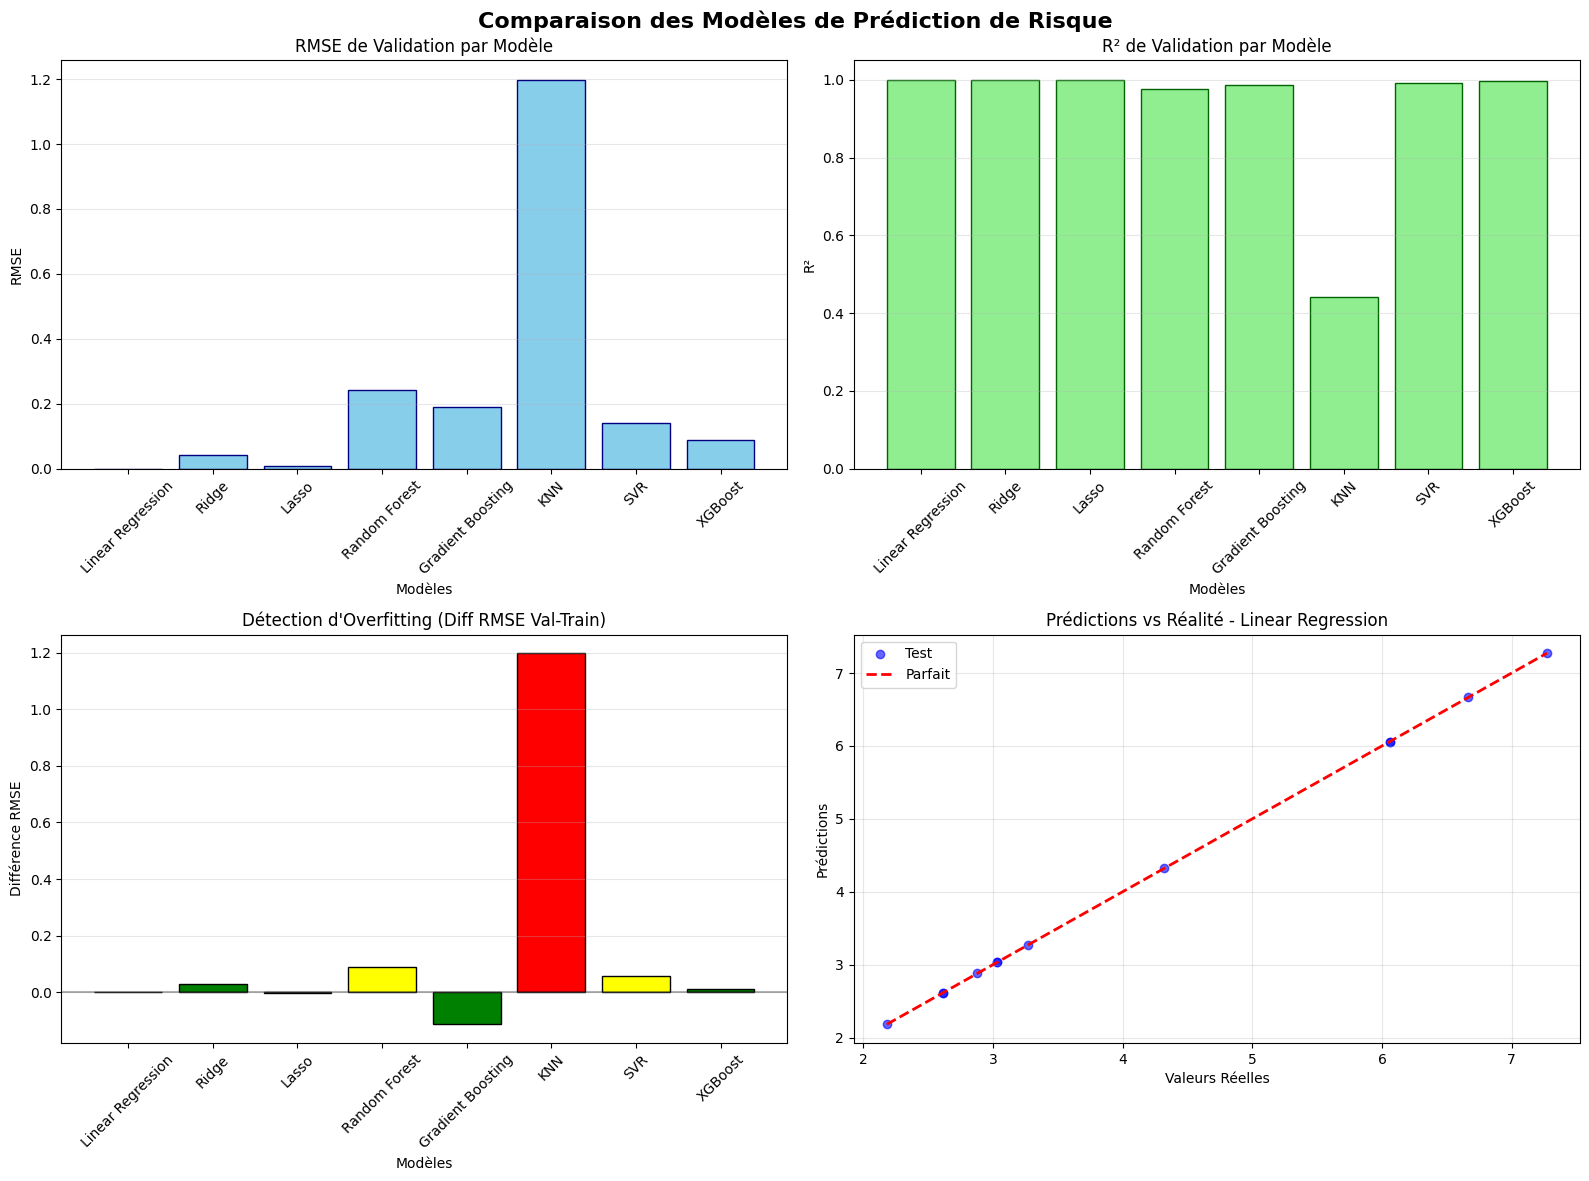

   ✅ Visualisations créées

🔍 ANALYSE D'IMPORTANCE DES FEATURES

🔬 Analyse pour Linear Regression...
   ✅ Coefficient magnitude calculée

   🏆 TOP 10 DES FEATURES:
       1. risk_score_normalized     | 2.2158
       2. day_cos                   | 0.0000
       3. incidents_per_weekday     | 0.0000
       4. is_night                  | 0.0000
       5. incidents_per_hour        | 0.0000
       6. incidents_per_month       | 0.0000
       7. day_sin                   | 0.0000
       8. is_weekend                | 0.0000
       9. month_sin                 | 0.0000
      10. high_severity_per_hour    | 0.0000


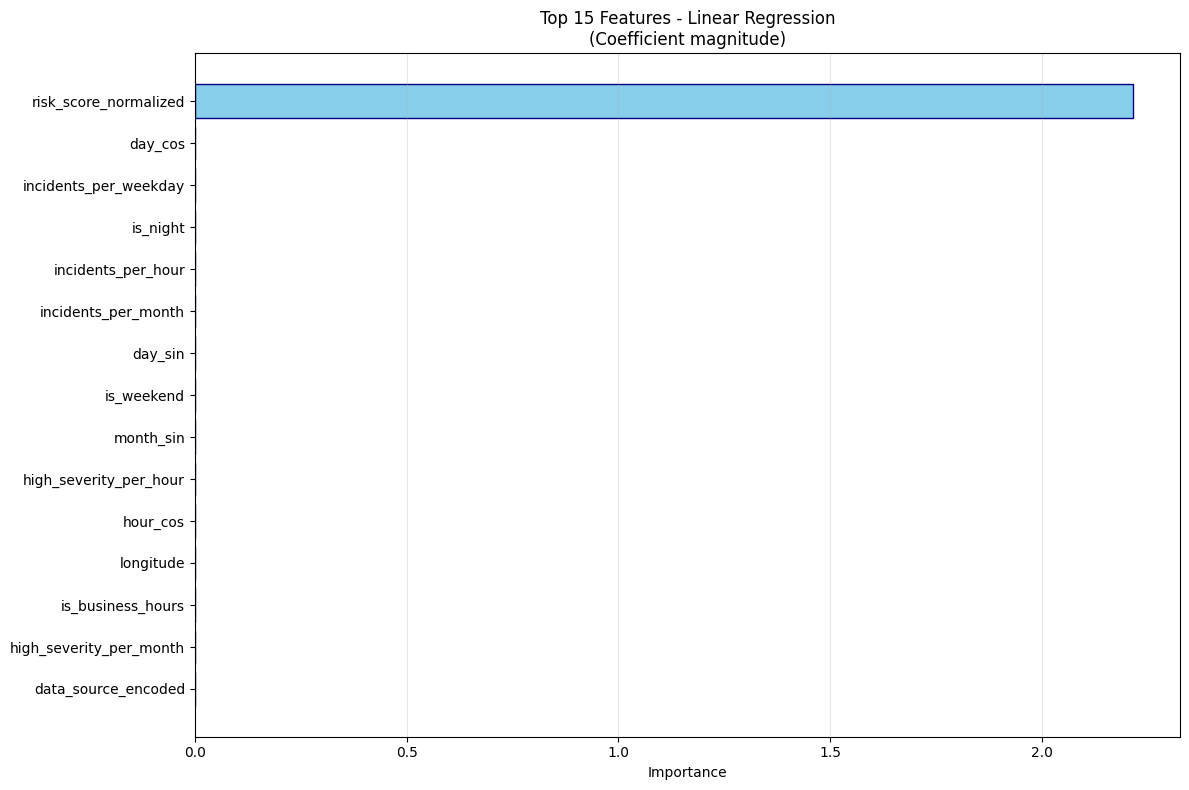


🧠 MODÈLE NEURAL NETWORK (OPTIONNEL)

🧠 Entraînement du réseau de neurones...
   ✅ Réseau de neurones entraîné:
      - Val RMSE: 0.795
      - Test RMSE: 1.332
      - Val R²: 0.754

🔄 Comparaison avec le meilleur modèle traditionnel:
   📊 Linear Regression reste meilleur (0.000 vs 0.795)

💾 SAUVEGARDE DU MODÈLE FINAL

📋 RÉSUMÉ DU DÉVELOPPEMENT DU MODÈLE

🚀 PROCHAINE ÉTAPE:
  Le modèle est prêt pour l'évaluation et le déploiement!
  Prochain notebook: 05_model_evaluation.ipynb

✨ DÉVELOPPEMENT DU MODÈLE TERMINÉ AVEC SUCCÈS


In [5]:
# Model Development - Modèle de Prédiction de Rues Risquées

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librairies Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import joblib

# Librairies avancées
try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("⚠️ XGBoost non installé - sera ignoré")

try:
    import keras
    from keras import layers
    HAS_TENSORFLOW = True
except ImportError:
    HAS_TENSORFLOW = False
    print("⚠️ TensorFlow non installé - sera ignoré")

print("🤖 Début du développement du modèle")
print("="*60)

# =====================================================================
# 1. CHARGEMENT DES FEATURES ENGINEERED
# =====================================================================

print("\n📁 Chargement des features engineered...")

def load_features_data():
    """Charge les données de feature engineering"""
    try:
        # Chargement de la matrice de features
        X = pd.read_parquet('../data/features/feature_matrix.parquet')
        y = pd.read_parquet('../data/features/target_variable.parquet')
        
        # Chargement des métadonnées
        import json
        with open('../data/features/feature_engineering_metadata.json', 'r') as f:
            metadata = json.load(f)
        
        print(f"✅ Features chargées:")
        print(f"  - Matrice X: {X.shape}")
        print(f"  - Variable cible y: {y.shape}")
        print(f"  - Nombre de features: {metadata['num_features']}")
        
        return X, y['risk_score'], metadata
        
    except FileNotFoundError as e:
        print(f"❌ Fichier non trouvé: {e}")
        print("   Vérifiez que le feature engineering a été exécuté")
        return None, None, None
    except Exception as e:
        print(f"❌ Erreur de chargement: {e}")
        return None, None, None

# Chargement des données
X_features, y_target, feature_metadata = load_features_data()

if X_features is not None:
    print(f"\n📊 Aperçu des données:")
    print(f"  - Nombre d'observations: {len(X_features):,}")
    print(f"  - Nombre de features: {X_features.shape[1]}")
    print(f"  - Variable cible - plage: [{y_target.min():.2f}, {y_target.max():.2f}]")
    print(f"  - Variable cible - moyenne: {y_target.mean():.2f} ± {y_target.std():.2f}")

# =====================================================================
# 2. PRÉPARATION DES DONNÉES POUR L'ENTRAÎNEMENT
# =====================================================================

print("\n" + "="*60)
print("🔧 PRÉPARATION DES DONNÉES")
print("="*60)

def prepare_data_for_training(X, y, test_size=0.2, val_size=0.1, random_state=42):
    """
    Prépare les données pour l'entraînement avec train/validation/test split
    """
    print(f"\n📋 Division des données...")
    
    # Premier split : train+val / test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=None
    )
    
    # Deuxième split : train / val
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=random_state
    )
    
    print(f"  ✅ Données divisées:")
    print(f"    - Train: {X_train.shape[0]:,} observations ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"    - Validation: {X_val.shape[0]:,} observations ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"    - Test: {X_test.shape[0]:,} observations ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def scale_features(X_train, X_val, X_test, method='standard'):
    """
    Normalise les features avec différentes méthodes
    """
    print(f"\n🔄 Normalisation des features (méthode: {method})...")
    
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        print(f"⚠️ Méthode {method} non reconnue, utilisation de StandardScaler")
        scaler = StandardScaler()
    
    # Fit sur train, transform sur tous
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Conversion en DataFrame pour conserver les noms de colonnes
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_names, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)
    
    print(f"  ✅ Features normalisées")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Application de la préparation
if X_features is not None:
    # Division train/val/test
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(X_features, y_target)
    
    # Normalisation des features
    X_train_scaled, X_val_scaled, X_test_scaled, feature_scaler = scale_features(X_train, X_val, X_test)

# =====================================================================
# 3. DÉFINITION DES MODÈLES À TESTER
# =====================================================================

print("\n" + "="*60)
print("🎯 DÉFINITION DES MODÈLES")
print("="*60)

def get_models_to_test():
    """
    Définit les modèles à tester avec leurs hyperparamètres
    """
    models = {}
    
    # 1. Régression Linéaire (baseline)
    models['Linear Regression'] = {
        'model': LinearRegression(),
        'params': {}
    }
    
    # 2. Ridge Regression
    models['Ridge'] = {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1.0, 10.0, 100.0]}
    }
    
    # 3. Lasso Regression
    models['Lasso'] = {
        'model': Lasso(),
        'params': {'alpha': [0.01, 0.1, 1.0, 10.0]}
    }
    
    # 4. Random Forest
    models['Random Forest'] = {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    }
    
    # 5. Gradient Boosting
    models['Gradient Boosting'] = {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
    
    # 6. K-Nearest Neighbors
    models['KNN'] = {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance']
        }
    }
    
    # 7. Support Vector Regression
    models['SVR'] = {
        'model': SVR(),
        'params': {
            'kernel': ['rbf', 'linear'],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }
    }
    
    # 8. XGBoost (si disponible)
    if HAS_XGBOOST:
        models['XGBoost'] = {
            'model': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
            'params': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
        }
    
    return models

# Obtention des modèles
models_to_test = get_models_to_test()
print(f"\n🔬 Modèles à tester: {len(models_to_test)}")
for name in models_to_test.keys():
    print(f"  • {name}")

# =====================================================================
# 4. ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES
# =====================================================================

print("\n" + "="*60)
print("🚀 ENTRAÎNEMENT ET ÉVALUATION")
print("="*60)

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    """
    Évalue un modèle sur les différents ensembles de données
    """
    # Prédictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    # Calcul des métriques
    metrics = {}
    
    # Train
    metrics['train_rmse'] = np.sqrt(mean_squared_error(y_train, train_pred))
    metrics['train_mae'] = mean_absolute_error(y_train, train_pred)
    metrics['train_r2'] = r2_score(y_train, train_pred)
    
    # Validation
    metrics['val_rmse'] = np.sqrt(mean_squared_error(y_val, val_pred))
    metrics['val_mae'] = mean_absolute_error(y_val, val_pred)
    metrics['val_r2'] = r2_score(y_val, val_pred)
    
    # Test
    metrics['test_rmse'] = np.sqrt(mean_squared_error(y_test, test_pred))
    metrics['test_mae'] = mean_absolute_error(y_test, test_pred)
    metrics['test_r2'] = r2_score(y_test, test_pred)
    
    # Détection d'overfitting
    metrics['overfitting_rmse'] = metrics['val_rmse'] - metrics['train_rmse']
    metrics['overfitting_r2'] = metrics['train_r2'] - metrics['val_r2']
    
    return metrics, {'train': train_pred, 'val': val_pred, 'test': test_pred}

def train_and_evaluate_models(models_dict, X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Entraîne et évalue tous les modèles avec optimisation d'hyperparamètres
    """
    results = {}
    trained_models = {}
    
    for model_name, model_config in models_dict.items():
        print(f"\n🔄 Entraînement: {model_name}")
        
        model = model_config['model']
        param_grid = model_config['params']
        
        if param_grid:
            # Optimisation des hyperparamètres avec GridSearchCV
            grid_search = GridSearchCV(
                model, param_grid, cv=3, scoring='neg_mean_squared_error', 
                n_jobs=-1, verbose=0
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            
            print(f"  ✅ Meilleurs paramètres: {grid_search.best_params_}")
        else:
            # Pas d'optimisation pour les modèles simples
            best_model = model
            best_model.fit(X_train, y_train)
            print(f"  ✅ Modèle entraîné (pas d'optimisation)")
        
        # Évaluation
        metrics, predictions = evaluate_model(
            best_model, X_train, X_val, X_test, y_train, y_val, y_test, model_name
        )
        
        # Sauvegarde des résultats
        results[model_name] = metrics
        trained_models[model_name] = {
            'model': best_model,
            'predictions': predictions,
            'params': grid_search.best_params_ if param_grid else {}
        }
        
        print(f"  📊 Val RMSE: {metrics['val_rmse']:.3f}, R²: {metrics['val_r2']:.3f}")
    
    return results, trained_models

# Entraînement des modèles
if X_features is not None:
    model_results, trained_models = train_and_evaluate_models(
        models_to_test, X_train_scaled, X_val_scaled, X_test_scaled, 
        y_train, y_val, y_test
    )

# =====================================================================
# 5. COMPARAISON ET SÉLECTION DU MEILLEUR MODÈLE
# =====================================================================

print("\n" + "="*60)
print("📈 COMPARAISON DES MODÈLES")
print("="*60)

def compare_models(results):
    """
    Compare les performances des modèles et sélectionne le meilleur
    """
    # Création du DataFrame de comparaison
    comparison_df = pd.DataFrame(results).T
    
    # Tri par performance sur la validation (RMSE croissant)
    comparison_df = comparison_df.sort_values('val_rmse')
    
    print(f"\n🏆 CLASSEMENT DES MODÈLES (par Val RMSE):")
    print("="*60)
    for i, (model_name, row) in enumerate(comparison_df.iterrows(), 1):
        print(f"{i}. {model_name:20} | RMSE: {row['val_rmse']:.3f} | R²: {row['val_r2']:.3f} | Overfit: {row['overfitting_rmse']:.3f}")
    
    # Sélection du meilleur modèle
    best_model_name = comparison_df.index[0]
    best_metrics = comparison_df.iloc[0]
    
    print(f"\n🥇 MEILLEUR MODÈLE: {best_model_name}")
    print(f"   📊 Métriques de validation:")
    print(f"      - RMSE: {best_metrics['val_rmse']:.3f}")
    print(f"      - MAE: {best_metrics['val_mae']:.3f}")
    print(f"      - R²: {best_metrics['val_r2']:.3f}")
    print(f"   📊 Métriques de test:")
    print(f"      - RMSE: {best_metrics['test_rmse']:.3f}")
    print(f"      - MAE: {best_metrics['test_mae']:.3f}")
    print(f"      - R²: {best_metrics['test_r2']:.3f}")
    
    return comparison_df, best_model_name

def create_model_visualization(results, trained_models, y_val, y_test):
    """
    Crée des visualisations pour comparer les modèles
    """
    print(f"\n📊 Création des visualisations...")
    
    # Configuration
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comparaison des Modèles de Prédiction de Risque', fontsize=16, fontweight='bold')
    
    # 1. Performance des modèles
    ax1 = axes[0, 0]
    model_names = list(results.keys())
    val_rmse = [results[name]['val_rmse'] for name in model_names]
    val_r2 = [results[name]['val_r2'] for name in model_names]
    
    x_pos = np.arange(len(model_names))
    ax1.bar(x_pos, val_rmse, color='skyblue', edgecolor='navy')
    ax1.set_title('RMSE de Validation par Modèle')
    ax1.set_xlabel('Modèles')
    ax1.set_ylabel('RMSE')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(model_names, rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. R² des modèles
    ax2 = axes[0, 1]
    ax2.bar(x_pos, val_r2, color='lightgreen', edgecolor='darkgreen')
    ax2.set_title('R² de Validation par Modèle')
    ax2.set_xlabel('Modèles')
    ax2.set_ylabel('R²')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(model_names, rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Overfitting analysis
    ax3 = axes[1, 0]
    overfitting_rmse = [results[name]['overfitting_rmse'] for name in model_names]
    colors = ['red' if x > 0.1 else 'yellow' if x > 0.05 else 'green' for x in overfitting_rmse]
    ax3.bar(x_pos, overfitting_rmse, color=colors, edgecolor='black')
    ax3.set_title('Détection d\'Overfitting (Diff RMSE Val-Train)')
    ax3.set_xlabel('Modèles')
    ax3.set_ylabel('Différence RMSE')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(model_names, rotation=45)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Prédictions vs réalité pour le meilleur modèle
    ax4 = axes[1, 1]
    best_model_name = min(results.keys(), key=lambda x: results[x]['val_rmse'])
    best_predictions = trained_models[best_model_name]['predictions']
    
    ax4.scatter(y_test, best_predictions['test'], alpha=0.6, color='blue', label='Test')
    ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Parfait')
    ax4.set_title(f'Prédictions vs Réalité - {best_model_name}')
    ax4.set_xlabel('Valeurs Réelles')
    ax4.set_ylabel('Prédictions')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"   ✅ Visualisations créées")

# Comparaison des modèles
if 'model_results' in locals():
    model_comparison, best_model_name = compare_models(model_results)
    create_model_visualization(model_results, trained_models, y_val, y_test)

# =====================================================================
# 6. ANALYSE D'IMPORTANCE DES FEATURES
# =====================================================================

print("\n" + "="*60)
print("🔍 ANALYSE D'IMPORTANCE DES FEATURES")
print("="*60)

def analyze_feature_importance(best_model_name, trained_models, feature_names):
    """
    Analyse l'importance des features pour le meilleur modèle
    """
    print(f"\n🔬 Analyse pour {best_model_name}...")
    
    model = trained_models[best_model_name]['model']
    
    # Extraction de l'importance selon le type de modèle
    if hasattr(model, 'feature_importances_'):
        # Tree-based models (RF, GB, XGB)
        importance = model.feature_importances_
        importance_type = "Tree-based importance"
    elif hasattr(model, 'coef_'):
        # Linear models
        importance = np.abs(model.coef_)
        importance_type = "Coefficient magnitude"
    else:
        print(f"   ⚠️ Impossible d'extraire l'importance pour {best_model_name}")
        return None
    
    # Création du DataFrame d'importance
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(f"   ✅ {importance_type} calculée")
    print(f"\n   🏆 TOP 10 DES FEATURES:")
    for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
        print(f"      {i:2d}. {row['feature']:25} | {row['importance']:.4f}")
    
    # Visualisation
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', edgecolor='navy')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 15 Features - {best_model_name}\n({importance_type})')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

# Analyse d'importance
if 'best_model_name' in locals():
    feature_importance = analyze_feature_importance(
        best_model_name, trained_models, X_train_scaled.columns.tolist()
    )

# =====================================================================
# 7. MODÈLE NEURAL NETWORK (OPTIONNEL)
# =====================================================================

print("\n" + "="*60)
print("🧠 MODÈLE NEURAL NETWORK (OPTIONNEL)")
print("="*60)

def create_neural_network(input_dim, hidden_layers=[64, 32, 16], dropout_rate=0.2):
    """
    Crée un réseau de neurones pour la régression
    """
    if not HAS_TENSORFLOW:
        print("   ⚠️ TensorFlow non disponible - modèle neural network ignoré")
        return None
    
    model = keras.Sequential()
    
    # Couche d'entrée
    model.add(layers.Dense(hidden_layers[0], activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dropout(dropout_rate))
    
    # Couches cachées
    for units in hidden_layers[1:]:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    # Couche de sortie
    model.add(layers.Dense(1, activation='linear'))
    
    # Compilation
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

def train_neural_network(X_train, X_val, y_train, y_val, epochs=100, patience=10):
    """
    Entraîne le réseau de neurones
    """
    if not HAS_TENSORFLOW:
        return None, None
    
    print(f"\n🧠 Entraînement du réseau de neurones...")
    
    # Création du modèle
    model = create_neural_network(X_train.shape[1])
    
    # Callback pour early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True
    )
    
    # Entraînement
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Évaluation
    train_pred = model.predict(X_train, verbose=0).flatten()
    val_pred = model.predict(X_val, verbose=0).flatten()
    test_pred = model.predict(X_test_scaled, verbose=0).flatten()
    
    # Métriques
    nn_metrics = {}
    nn_metrics['train_rmse'] = np.sqrt(mean_squared_error(y_train, train_pred))
    nn_metrics['val_rmse'] = np.sqrt(mean_squared_error(y_val, val_pred))
    nn_metrics['test_rmse'] = np.sqrt(mean_squared_error(y_test, test_pred))
    nn_metrics['train_r2'] = r2_score(y_train, train_pred)
    nn_metrics['val_r2'] = r2_score(y_val, val_pred)
    nn_metrics['test_r2'] = r2_score(y_test, test_pred)
    
    print(f"   ✅ Réseau de neurones entraîné:")
    print(f"      - Val RMSE: {nn_metrics['val_rmse']:.3f}")
    print(f"      - Test RMSE: {nn_metrics['test_rmse']:.3f}")
    print(f"      - Val R²: {nn_metrics['val_r2']:.3f}")
    
    return model, nn_metrics

# Entraînement du neural network
if X_features is not None and HAS_TENSORFLOW:
    nn_model, nn_metrics = train_neural_network(X_train_scaled, X_val_scaled, y_train, y_val)
    
    # Comparaison avec les autres modèles
    if nn_metrics:
        print(f"\n🔄 Comparaison avec le meilleur modèle traditionnel:")
        best_val_rmse = model_results[best_model_name]['val_rmse']
        if nn_metrics['val_rmse'] < best_val_rmse:
            print(f"   🥇 Neural Network est meilleur! ({nn_metrics['val_rmse']:.3f} vs {best_val_rmse:.3f})")
            final_model = nn_model
            final_model_name = "Neural Network"
            final_metrics = nn_metrics
        else:
            print(f"   📊 {best_model_name} reste meilleur ({best_val_rmse:.3f} vs {nn_metrics['val_rmse']:.3f})")
            final_model = trained_models[best_model_name]['model']
            final_model_name = best_model_name
            final_metrics = model_results[best_model_name]
else:
    final_model = trained_models[best_model_name]['model'] if 'best_model_name' in locals() else None
    final_model_name = best_model_name if 'best_model_name' in locals() else None
    final_metrics = model_results[best_model_name] if 'best_model_name' in locals() else None

# =====================================================================
# 8. SAUVEGARDE DU MODÈLE FINAL
# =====================================================================

print("\n" + "="*60)
print("💾 SAUVEGARDE DU MODÈLE FINAL")
print("="*60)

def save_final_model(model, model_name, scaler, feature_names, metrics, metadata):
    """
    Sauvegarde le modèle final et toutes les métadonnées nécessaires
    """
    print(f"\n💾 Sauvegarde du modèle final...")
    
    import os
    import json
    
    # Création du dossier
    output_dir = '../models'
    os.makedirs(output_dir, exist_ok=True)
    
    # Sauvegarde du modèle
    if final_model_name == "Neural Network" and HAS_TENSORFLOW:
        model.save(f'{output_dir}/risk_prediction_model.h5')
        model_file = f'{output_dir}/risk_prediction_model.h5'
        print(f"   ✅ Modèle Neural Network sauvegardé: {model_file}")
    else:
        model_file = f'{output_dir}/risk_prediction_model.joblib'
        joblib.dump(model, model_file)
        print(f"   ✅ Modèle {model_name} sauvegardé: {model_file}")
    
    # Sauvegarde du scaler
    scaler_file = f'{output_dir}/feature_scaler.joblib'
    joblib.dump(scaler, scaler_file)
    print(f"   ✅ Scaler sauvegardé: {scaler_file}")
    
    # Métadonnées du modèle
    model_metadata = {
        'model_training_date': datetime.now().isoformat(),
        'model_name': model_name,
        'model_type': 'neural_network' if model_name == "Neural Network" else 'sklearn',
        'feature_names': feature_names,
        'num_features': len(feature_names),
        'scaler_type': type(scaler).__name__,
        'metrics': {
            'train_rmse': float(metrics['train_rmse']),
            'val_rmse': float(metrics['val_rmse']),
            'test_rmse': float(metrics['test_rmse']),
            'train_r2': float(metrics['train_r2']),
            'val_r2': float(metrics['val_r2']),
            'test_r2': float(metrics['test_r2'])
        },
        'data_info': {
            'train_size': len(y_train),
            'val_size': len(y_val),
            'test_size': len(y_test),
            'total_incidents': metadata['total_incidents']
        },
        'model_files': {
            'model': model_file,
            'scaler': scaler_file
        }
    }
    
    # Ajout des paramètres du modèle si disponible
    if model_name in trained_models and 'params' in trained_models[model_name]:
        model_metadata['best_params'] = trained_models[model_name]['params']
    
    # Sauvegarde des métadonnées
    metadata_file = f'{output_dir}/model_metadata.json'
    with open(metadata_file, 'w') as f:
        json.dump(model_metadata, f, indent=2, default=str)
    print(f"   ✅ Métadonnées sauvegardées: {metadata_file}")
    
    # Création d'un script de prédiction
    prediction_script = f'''# Script de Prédiction - Modèle de Rues Risquées
# Généré automatiquement le {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

import joblib
import pandas as pd
import numpy as np
{"import tensorflow as tf" if model_name == "Neural Network" else ""}

def load_model():
    """Charge le modèle et le scaler"""
    {"model = tf.keras.models.load_model('risk_prediction_model.h5')" if model_name == "Neural Network" else "model = joblib.load('risk_prediction_model.joblib')"}
    scaler = joblib.load('feature_scaler.joblib')
    return model, scaler

def predict_risk_score(features_dict):
    """
    Prédit le score de risque pour un nouveau point
    
    Args:
        features_dict: Dictionnaire avec les features
        {{
            'latitude': 42.3501,
            'longitude': -71.0589,
            'hour_sin': 0.5,
            # ... autres features
        }}
    
    Returns:
        Score de risque normalisé (0-10)
    """
    model, scaler = load_model()
    
    # Création du DataFrame avec les bonnes colonnes
    feature_names = {model_metadata['feature_names']}
    features_df = pd.DataFrame([features_dict])[feature_names]
    
    # Normalisation
    features_scaled = scaler.transform(features_df)
    
    # Prédiction
    {"prediction = model.predict(features_scaled)[0][0]" if model_name == "Neural Network" else "prediction = model.predict(features_scaled)[0]"}
    
    return float(prediction)

# Exemple d'utilisation
if __name__ == "__main__":
    # Exemple de features
    example_features = {{
        # Ajoutez ici les valeurs d'exemple pour toutes les features
        # {dict(zip(feature_names, ['0.0'] * len(feature_names)))}
    }}
    
    risk_score = predict_risk_score(example_features)
    print(f"Score de risque prédit: {{risk_score:.2f}}")
'''
    
    script_file = f'{output_dir}/predict_risk.py'
    with open(script_file, 'w') as f:
        f.write(prediction_script)
    print(f"   ✅ Script de prédiction créé: {script_file}")
    
    return model_metadata

# Sauvegarde du modèle final
if all(var in locals() for var in ['final_model', 'final_model_name', 'feature_scaler']):
    saved_metadata = save_final_model(
        final_model, final_model_name, feature_scaler, 
        X_train_scaled.columns.tolist(), final_metrics, feature_metadata
    )

# =====================================================================
# 9. RÉSUMÉ DU DÉVELOPPEMENT
# =====================================================================

print("\n" + "="*60)
print("📋 RÉSUMÉ DU DÉVELOPPEMENT DU MODÈLE")
print("="*60)

if 'saved_metadata' in locals():
    print(f"\n🎯 MODÈLE FINAL SÉLECTIONNÉ: {saved_metadata['model_name']}")
    print(f"\n📊 PERFORMANCES FINALES:")
    metrics = saved_metadata['metrics']
    print(f"  • Entraînement - RMSE: {metrics['train_rmse']:.3f}, R²: {metrics['train_r2']:.3f}")
    print(f"  • Validation   - RMSE: {metrics['val_rmse']:.3f}, R²: {metrics['val_r2']:.3f}")
    print(f"  • Test         - RMSE: {metrics['test_rmse']:.3f}, R²: {metrics['test_r2']:.3f}")
    
    print(f"\n📁 FICHIERS GÉNÉRÉS:")
    for file_type, filepath in saved_metadata['model_files'].items():
        print(f"  • {file_type.capitalize()}: {filepath}")
    print(f"  • Métadonnées: ../models/model_metadata.json")
    print(f"  • Script de prédiction: ../models/predict_risk.py")
    
    print(f"\n🔢 DONNÉES D'ENTRAÎNEMENT:")
    data_info = saved_metadata['data_info']
    print(f"  • Train: {data_info['train_size']:,} observations")
    print(f"  • Validation: {data_info['val_size']:,} observations")
    print(f"  • Test: {data_info['test_size']:,} observations")
    print(f"  • Total incidents: {data_info['total_incidents']:,}")
    
    if 'feature_importance' in locals() and feature_importance is not None:
        print(f"\n🏆 TOP 5 FEATURES LES PLUS IMPORTANTES:")
        for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
            print(f"  {i}. {row['feature']}")

print(f"\n🚀 PROCHAINE ÉTAPE:")
print("  Le modèle est prêt pour l'évaluation et le déploiement!")
print("  Prochain notebook: 05_model_evaluation.ipynb")

print("\n" + "="*60)
print("✨ DÉVELOPPEMENT DU MODÈLE TERMINÉ AVEC SUCCÈS")
print("="*60)